In [1]:
import sys
sys.path.append('../..')
from utils.workflow import WorkflowModel
from utils.data import RK4DataGenerator, stack_real_values, mono_beta
import utils.plotting as plotting
from utils.eval import eval_predictions, format_latex_table
import numpy as np

2026-02-11 10:30:15.846719: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-11 10:30:16.272041: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-11 10:30:17.995138: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Set the default float type to float64


E0000 00:00:1770816620.185371 1024141 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1770816620.199908 1024141 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
t_0, t_f, N = 0, 50, 100
nop_data = 100
S0, I0, R0 = 99, 1, 0
noise_std = N * 0.02
data_t = np.linspace(t_0, t_f, nop_data)
rkdata = RK4DataGenerator(mono_beta, 
    t_0=t_0, 
    t_f=t_f, 
    N=N, 
    S0=S0, I0=I0, R0=R0
)
sir_real = rkdata.generate(data_t)
sir_data = rkdata.generate(data_t, noise_std)

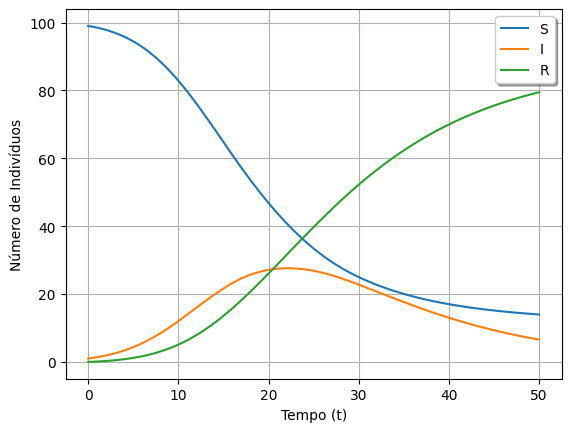

In [3]:
plotting.plot_rk_curves(data_t, sir_real)

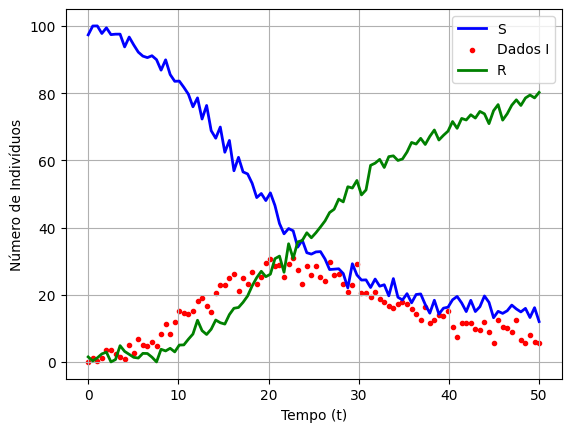

In [4]:
plotting.plot_rk_data(data_t, sir_data)

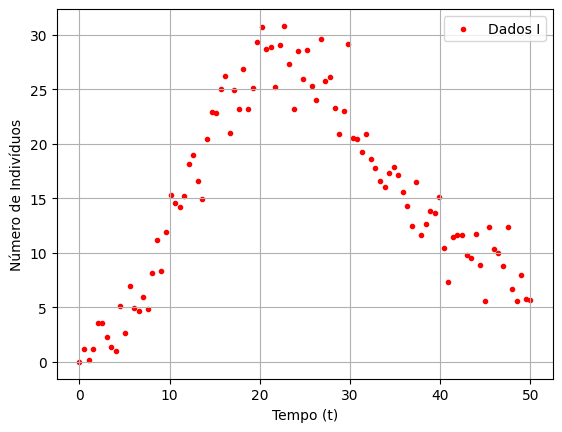

In [5]:
plotting.plot_incidence_data(data_t, sir_data[:,1], "prevalence-example-noisy")

In [6]:
model = WorkflowModel(t_0, t_f, sir_data[:,1], data_t,
    N=N,
    beta_estimation_window=4,
    hidden_layer_size=50,
    n_hidden_layers=3,
    # w_physics=2000,
    scaling="min/max",
    activation="tanh",
    adam_iterations=300000,
    estimate_beta=True,
    parallel_pinns=False,
    early_stopping=True,
    adaptative_wdata=True,
    fine_tunning_using_lbfgs=False,
    beta_hard_constraints=False)
model.S0, model.I0, model.beta0

Compiling model...
'compile' took 0.005562 s



/home/gabriel/Documents/inverse-cm/notebooks/synthetic_data/../../utils/data.py:86: RuntimeWarning: divide by zero encountered in log
  logI = np.log(I_data[:window])


(np.float64(3.2438421220410314), np.float64(0.0), np.float64(nan))

In [7]:
model.train()

(<deepxde.model.LossHistory at 0x7f865cca30d0>,
 <deepxde.model.TrainState at 0x7f865cca3110>)

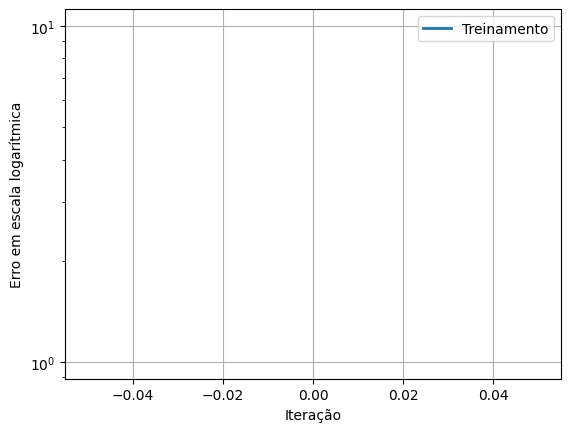

In [8]:
plotting.plot_losshistory(model.losshistory, "loss-mono-beta-noise")

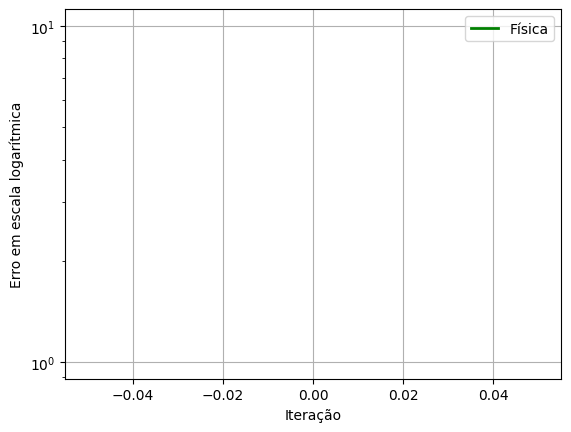

In [9]:
plotting.plot_phys_losshistory(model.losshistory, model.n_physics, "loss-physics-mono-beta-noise")

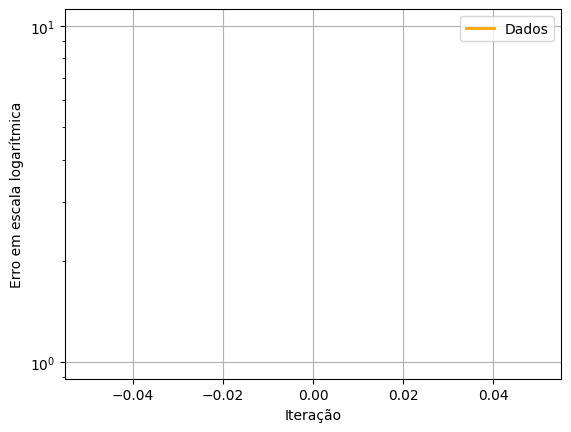

In [10]:
plotting.plot_data_losshistory(model.losshistory, "loss-data-mono-beta-noise")

In [11]:
test_t = np.linspace(t_0, t_f, nop_data)
predictions = model.predict(test_t)

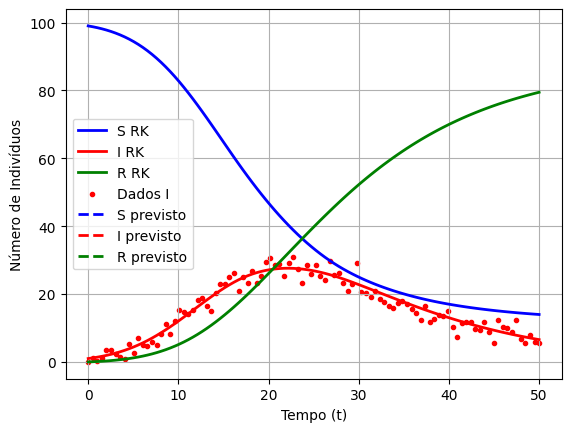

In [12]:
plotting.plot_results(sir_real, sir_data, predictions, test_t, N=N, 
    figname="results-mono-beta-noise")

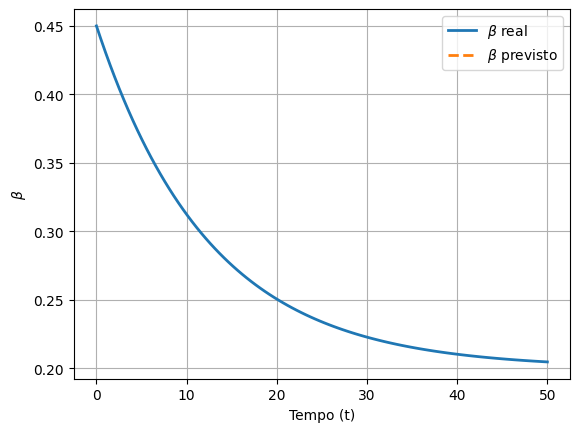

In [13]:
real_beta = mono_beta(test_t)
plotting.plot_beta_comparison(real_beta, predictions[:,2], test_t, 
    figname="predicted-mono-beta-noise")

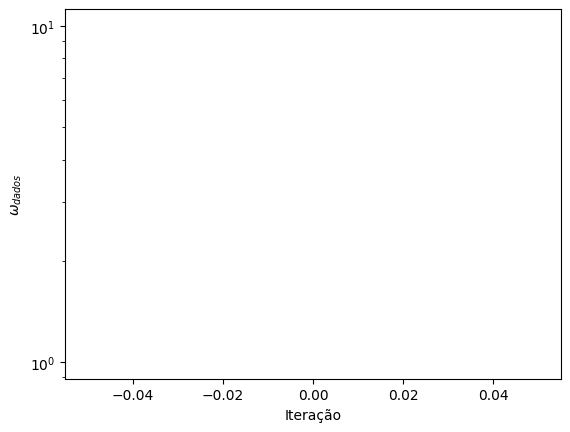

In [14]:
if model.data_weight_hist:
    plotting.plot_wdata(model.data_weight_hist)

In [15]:
real_values = stack_real_values(sir_real, real_beta)
predictions = eval_predictions(real_values, predictions)

ValueError: Input contains NaN.

In [ ]:
predictions

,compartiment,RMSE,L2,L-infinity
0,S,2.146067,0.039181,3.279140
1,I,0.267689,0.015033,0.560161
2,beta,0.028252,0.104667,0.051961


In [ ]:
format_latex_table(predictions)

'\\begin{tabular}{llrrr}\n\\toprule\n & compartiment & RMSE & L2 & L-infinity \\\\\n\\midrule\n0 & S & 2.146067 & 0.039181 & 3.279140 \\\\\n1 & I & 0.267689 & 0.015033 & 0.560161 \\\\\n2 & beta & 0.028252 & 0.104667 & 0.051961 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
model.formated_total_training_time

'01:36:55'